In [1]:
!pip install scikit-image

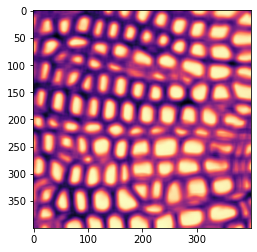

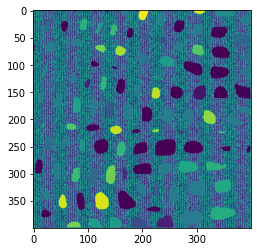

In [6]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from skimage.color import rgb2gray
import time
from unionfindopt import *

def load_cells_grayscale(filename, n_pixels = 0):
    """
    Load in a grayscale image of the cells, where 1 is maximum brightness
    and 0 is minimum brightness

    Parameters
    ----------
    filename: string
        Path to image holding the cells
    n_pixels: int
        Number of pixels in the image
    
    Returns
    -------
    ndarray(N, N)
        A square grayscale image
    """
    cells_original = skimage.io.imread(filename)
    cells_gray = rgb2gray(cells_original)
    # Denoise a bit with a uniform filter
    cells_gray = ndimage.uniform_filter(cells_gray, size=10)
    cells_gray = cells_gray - np.min(cells_gray)
    cells_gray = cells_gray/np.max(cells_gray)
    N = int(np.sqrt(n_pixels))
    if n_pixels > 0:
        # Resize to a square image
        cells_gray = resize(cells_gray, (N, N), anti_aliasing=True)
    return cells_gray


def permute_labels(labels):
    """
    Shuffle around labels by raising them to a prime and
    modding by a large-ish prime, so that cells are easier
    to see against their backround
    Parameters
    ----------
    labels: ndarray(M, N)
        An array of labels for the pixels in the image
    Returns
    -------
    labels_shuffled: ndarray(M, N)
        A new image where the labels are different but still
        the same within connected components
    """
    return (labels**31) % 833

def get_cell_labels(I, thresh):
    u = UnionFindOpt(len(I) * len(I))
    label = list()
    for i in range(len(I)):
        label.append(np.arange(len(I)*i, len(I)*(i+1)))
    label = np.array(label) 
    for i in range(len(I) - 1):
        #for j in range(len(I) - 1):
        for j in range(len(I[i]) - 1):
            if I[i][j] > thresh and I[i+1][j] > thresh:
                u.union(label[i,j], label[i+1,j])
            if I[i][j] > thresh and I[i][j+1] > thresh:
                u.union(label[i,j], label[i,j+1])
                
    for i in range(len(I) - 1):
        for j in range(len(I[i]) - 1):
            label[i][j] = u.root(label[i][j])

    return label

if __name__ == '__main__':
    I = load_cells_grayscale("Cells.jpg")
    plt.imshow(I, cmap='magma')
    plt.show()
    
thresh = 0.8
I = load_cells_grayscale("Cells.jpg")
labels = get_cell_labels(I, thresh)
# permute_labels shuffles around the labels to make it 
# easier to view the cells against their background
plt.imshow(permute_labels(labels))
plt.show()     

In [7]:
def get_cluster_centers(labels):
    clusterDict = {}
    #labels = []
    centers = []
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[i][j] not in clusterDict:
                clusterDict[labels[i][j]] = []
                clusterDict[labels[i][j]].append((i,j))
            else:
                clusterDict[labels[i][j]].append((i,j))
    for i in clusterDict:
        iSum = 0
        jSum = 0
        if len(clusterDict[i]) > 1:
            for j in clusterDict[i]:   
                #if i > 1:
                iSum += j[0]
                jSum += j[1]

                x = iSum/len(clusterDict[i])
                y = jSum/len(clusterDict[i])

            center = (x,y)
            centers.append(center)
    return centers

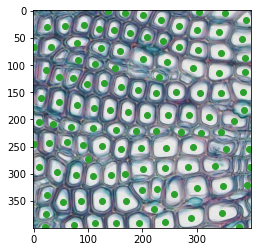

In [8]:
thresh = 0.8
I = load_cells_grayscale("Cells.jpg")
labels = get_cell_labels(I, thresh)
cells_original = skimage.io.imread("Cells.jpg")
X = get_cluster_centers(labels)
X = np.array(X)
plt.imshow(cells_original)
plt.scatter(X[:, 1], X[:, 0], c='C2')
plt.show()